## Monthly VARX Model 

Data period: 2000-01-31 to 2025-11-30
Total observations: 311

Columns: ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']

Training period: 2000-01-31 → 2020-08-31
Test period: 2020-09-30 → 2025-11-30

Estimating VARX model with 2 lags...

=== Model Summary ===
                             Statespace Model Results                            
Dep. Variable:     ['Q', 'd_pi', 'dI_t']   No. Observations:                  248
Model:                           VARX(2)   Log Likelihood                1828.822
                             + intercept   AIC                          -3567.644
Date:                   Tue, 18 Nov 2025   BIC                          -3409.540
Time:                           10:58:25   HQIC                         -3503.997
Sample:                       01-31-2000                                         
                            - 08-31-2020                                         
Covariance Type:                     

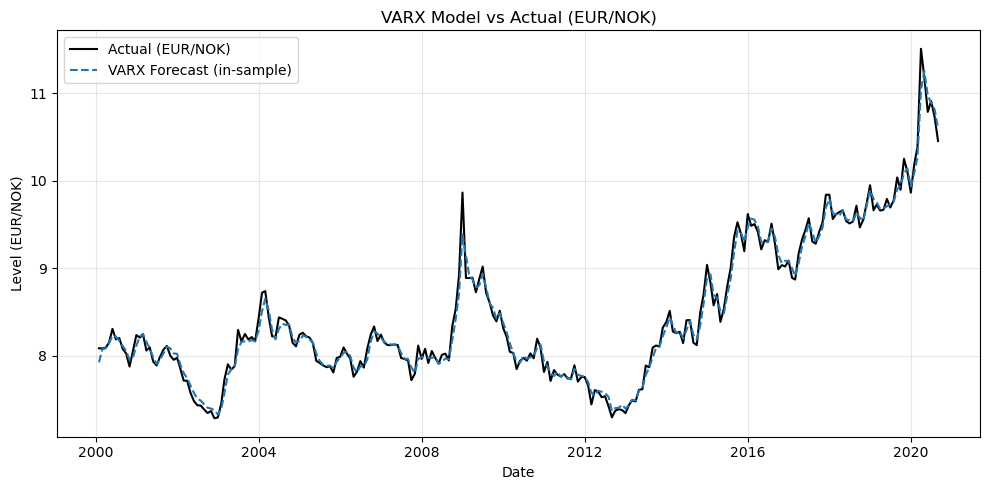

In [8]:
# ==============================================
# VARX model for EUR/NOK with exogenous variables
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 1) Load dataset directly from GitHub
# ----------------------------
url = "https://raw.githubusercontent.com/bredeespelid/Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"

df = pd.read_csv(url)

# Convert and sort by date
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in column names.")

df = df.sort_values("Date").set_index("Date")

print(f"Data period: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")
print("\nColumns:", list(df.columns))

# ----------------------------
# 2) Prepare variables
# ----------------------------
# Endogenous variables (same as in VAR)
endog_vars = ["Q", "d_pi", "dI_t"]

# Exogenous variables (to be log-transformed)
exog_vars = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]

# Create copies for transformation
df = df.copy()

# Log-transform Q (real exchange rate)
df["Q"] = np.log(df["Q"])

# Log-transform all exogenous variables
for var in exog_vars:
    df[var] = np.log(df[var])

# Define endogenous and exogenous dataframes
endog = df[endog_vars]
exog = df[exog_vars]

# ----------------------------
# 3) Split into train/test sets
# ----------------------------
train_size = int(len(df) * 0.8)
train_endog, test_endog = endog.iloc[:train_size], endog.iloc[train_size:]
train_exog,  test_exog  = exog.iloc[:train_size],  exog.iloc[train_size:]
train_target, test_target = df["EUR_NOK"].iloc[:train_size], df["EUR_NOK"].iloc[train_size:]

print(f"\nTraining period: {train_endog.index.min().date()} → {train_endog.index.max().date()}")
print(f"Test period: {test_endog.index.min().date()} → {test_endog.index.max().date()}")

# ----------------------------
# 4) Estimate VARX model
# ----------------------------
p = 2  # lag length (same as VAR)
print(f"\nEstimating VARX model with {p} lags...")

model = VARMAX(train_endog, exog=train_exog, order=(p, 0))
results = model.fit(maxiter=1000, disp=False)

print("\n=== Model Summary ===")
print(results.summary())

# ----------------------------
# 5) Generate in-sample predictions
# ----------------------------
pred = results.get_prediction(start=0, end=len(train_endog)-1, exog=train_exog)
pred_mean = pred.predicted_mean

# ----------------------------
# 6) Reconstruct nominal EUR/NOK (in-sample)
# ----------------------------
g_true = np.log(train_target) - train_endog["Q"]
s_hat = pred_mean["Q"] + g_true
eur_nok_pred = np.exp(s_hat)

# ----------------------------
# 7) Evaluate in-sample performance
# ----------------------------
comparison = pd.concat([train_target, eur_nok_pred], axis=1)
comparison.columns = ["actual", "predicted"]
comparison = comparison.dropna()

actual = comparison["actual"]
predicted = comparison["predicted"]

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae  = mean_absolute_error(actual, predicted)
directional_accuracy = np.mean(
    np.sign(np.diff(actual)) == np.sign(np.diff(predicted))
) * 100

print(f"\n=== VARX Forecasting Performance (in-sample) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"Directional accuracy: {directional_accuracy:.1f}%")

# ----------------------------
# 8) Plot actual vs predicted (in-sample)
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(actual.index, actual, label="Actual (EUR/NOK)", color="black")
plt.plot(predicted.index, predicted, label="VARX Forecast (in-sample)",
         color="tab:blue", linestyle="--")
plt.title("VARX Model vs Actual (EUR/NOK)")
plt.ylabel("Level (EUR/NOK)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VARX_Model.png", dpi=300, bbox_inches="tight")
plt.show()


## Quarterly VARX Model 


=== Quarterly Evaluation (Aggregated from Monthly VARX) ===
RMSE (quarterly): 0.0621
MAE (quarterly): 0.0444
Directional accuracy (quarterly): 86.6%


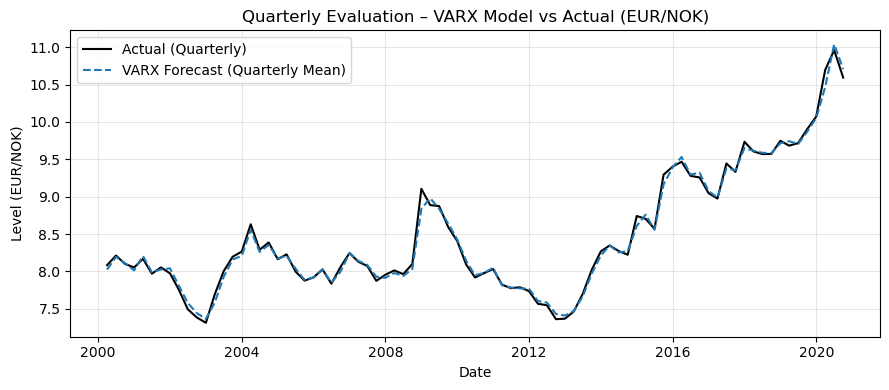

In [9]:
# ==============================================
# VARX model – Quarterly Evaluation (aggregated from monthly results)
# ==============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ----------------------------
# 1) Aggregate monthly predictions to quarterly means
# ----------------------------
# Use EUR_NOK as actual (not logged)
# Both 'actual' and 'predicted' are already in nominal level form
comparison_q = pd.concat([actual, predicted], axis=1).dropna()
comparison_q.columns = ["actual", "predicted"]

# Resample to quarterly frequency (mean of each quarter)
actual_quarterly = comparison_q["actual"].resample("Q").mean()
predicted_quarterly = comparison_q["predicted"].resample("Q").mean()

# ----------------------------
# 2) Compute quarterly evaluation metrics
# ----------------------------
rmse_q = np.sqrt(mean_squared_error(actual_quarterly, predicted_quarterly))
mae_q = mean_absolute_error(actual_quarterly, predicted_quarterly)
directional_accuracy_q = np.mean(
    np.sign(np.diff(actual_quarterly)) == np.sign(np.diff(predicted_quarterly))
) * 100

print("\n=== Quarterly Evaluation (Aggregated from Monthly VARX) ===")
print(f"RMSE (quarterly): {rmse_q:.4f}")
print(f"MAE (quarterly): {mae_q:.4f}")
print(f"Directional accuracy (quarterly): {directional_accuracy_q:.1f}%")

# ----------------------------
# 3) Plot quarterly actual vs predicted series
# ----------------------------
plt.figure(figsize=(9, 4))
plt.plot(actual_quarterly.index, actual_quarterly, label="Actual (Quarterly)", color="black")
plt.plot(predicted_quarterly.index, predicted_quarterly,
         label="VARX Forecast (Quarterly Mean)", color="tab:blue", linestyle="--")
plt.title("Quarterly Evaluation – VARX Model vs Actual (EUR/NOK)")
plt.ylabel("Level (EUR/NOK)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VARX_Quarterly_Evaluation.png", dpi=300, bbox_inches="tight")
plt.show()


### DM Test

In [10]:
import math
import numpy as np
import pandas as pd

def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h: int = 1, loss: str = "mse"):
    """
    Diebold–Mariano test for equal predictive accuracy.

    Parameters:
        y_true  : actual values
        y_model : model forecast
        y_rw    : benchmark forecast (e.g., random walk)
        h       : forecast horizon (use h=1 for one-step forecasts)
        loss    : "mse" or "mae"

    Returns:
        (DM statistic, p-value)
    """

    # Align series
    df = pd.concat(
        {
            "y": pd.Series(y_true),
            "m": pd.Series(y_model),
            "rw": pd.Series(y_rw),
        },
        axis=1,
    ).dropna()

    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    # Forecast errors
    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    # Loss differentials
    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:  # mse
        d = (e_m ** 2) - (e_r ** 2)

    N = int(len(d))
    d_mean = float(d.mean())

    # Variance of d_t (HAC with Bartlett weights)
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    # DM statistic and p-value (normal approximation)
    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))

    return dm_stat, p_val


## VARX Walk-Forward Forecast – Monthly Evaluation 



=== Starting VARX Walk-Forward Monthly Evaluation (parallel) ===
Training period: 2000-01-31 → 2020-08-31
Test period:     2020-09-30 → 2025-11-30
Out-of-sample months: 63


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
/opt/anacond

Completed 63 monthly forecasts.

=== VARX Walk-Forward Evaluation (Monthly) ===
Observations: 63
RMSE: 0.2901
MAE:  0.2294
Directional accuracy: 66.1%

=== Diebold–Mariano Test vs Random Walk (Monthly) ===
DM-statistic: -0.6073
p-value: 0.5436


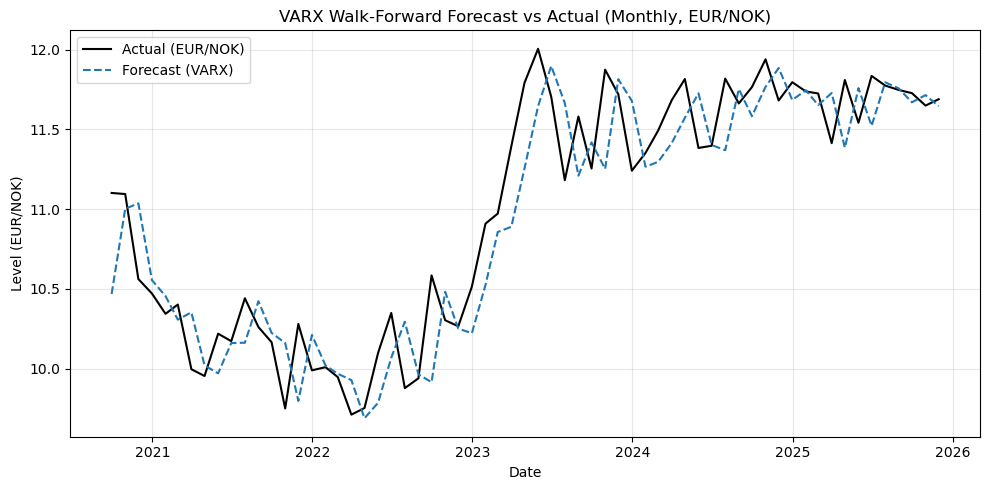

Saved: VARX_WalkForward_Monthly.png


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")

print("\n\n=== Starting VARX Walk-Forward Monthly Evaluation (parallel) ===")

# ----------------------------
# 1) Setup and parameters
# ----------------------------
p = 2  # lag order
train_cut = int(len(df) * 0.8)

endog_m = df[endog_vars]
exog_m  = df[exog_vars]
eur_nok_m = df["EUR_NOK"]

dates = list(eur_nok_m.index)

print(f"Training period: {eur_nok_m.index[0].date()} → {eur_nok_m.index[train_cut-1].date()}")
print(f"Test period:     {eur_nok_m.index[train_cut].date()} → {eur_nok_m.index[-1].date()}")
print(f"Out-of-sample months: {len(df) - train_cut}")

# ----------------------------
# 2) Helper: forecast one step ahead (samme som før)
# ----------------------------
def forecast_one_step_monthly(endog_train, exog_train, exog_next, g_prev, p=2):
    model = VARMAX(endog_train, exog=exog_train, order=(p, 0))
    res = model.fit(maxiter=500, disp=False)
    f = res.get_forecast(steps=1, exog=exog_next).predicted_mean.iloc[0]
    q_hat, dpi_hat = f["Q"], f["d_pi"]

    # Reconstruct nominal rate using last price gap
    g_new = g_prev - dpi_hat
    s_hat = q_hat + g_new
    return np.exp(s_hat), g_new

# ----------------------------
# 3) En enkelt-funksjon for ett tidspunkt (kan parallelliseres)
# ----------------------------
def one_month_forecast(i):
    """
    Kjører *nøyaktig* samme logikk som i den originale løkken for én måned.
    Returnerer dict med date, y_true, y_pred eller None hvis for kort treningsperiode.
    """
    d_prev = dates[i - 1]
    d_curr = dates[i]

    endog_train = endog_m.loc[:d_prev]
    exog_train  = exog_m.loc[:d_prev]
    exog_next   = exog_m.loc[[d_curr]]

    if len(endog_train) < 24:
        return None

    # Compute last price gap from previous observation
    q_T = endog_train["Q"].iloc[-1]
    s_T = np.log(eur_nok_m.loc[d_prev])
    g_prev = s_T - q_T

    # Forecast next month (samme funksjon som før)
    y_pred, _ = forecast_one_step_monthly(endog_train, exog_train, exog_next, g_prev, p=p)
    y_true = eur_nok_m.loc[d_curr]

    return {"date": d_curr, "y_true": y_true, "y_pred": y_pred}

# ----------------------------
# 4) Parallel walk-forward
# ----------------------------
results = Parallel(n_jobs=-1, backend="loky", verbose=1)(
    delayed(one_month_forecast)(i) 
    for i in range(train_cut, len(dates))
)

rows = [r for r in results if r is not None]

df_eval_m = pd.DataFrame(rows).set_index("date").sort_index()
print(f"Completed {len(df_eval_m)} monthly forecasts.")

# ----------------------------
# 5) Evaluate predictive performance
# ----------------------------
rmse_m = np.sqrt(mean_squared_error(df_eval_m["y_true"], df_eval_m["y_pred"]))
mae_m = mean_absolute_error(df_eval_m["y_true"], df_eval_m["y_pred"])

df_eval_m["y_prev"] = df_eval_m["y_true"].shift(1)
mask = df_eval_m["y_prev"].notna()
dir_true = np.sign(df_eval_m.loc[mask, "y_true"] - df_eval_m.loc[mask, "y_prev"])
dir_pred = np.sign(df_eval_m.loc[mask, "y_pred"] - df_eval_m.loc[mask, "y_prev"])
hit_rate_m = (dir_true == dir_pred).mean() * 100

print("\n=== VARX Walk-Forward Evaluation (Monthly) ===")
print(f"Observations: {len(df_eval_m)}")
print(f"RMSE: {rmse_m:.4f}")
print(f"MAE:  {mae_m:.4f}")
print(f"Directional accuracy: {hit_rate_m:.1f}%")

# ----------------------------
# 6) Diebold–Mariano vs Random Walk (monthly)
# ----------------------------
df_eval_m["rw_pred"] = df_eval_m["y_true"].shift(1)
dm_stat_m, p_val_m = dm_test(df_eval_m["y_true"], df_eval_m["y_pred"], df_eval_m["rw_pred"], h=1, loss="mse")

print("\n=== Diebold–Mariano Test vs Random Walk (Monthly) ===")
print(f"DM-statistic: {dm_stat_m:.4f}")
print(f"p-value: {p_val_m:.4f}")

# ----------------------------
# 7) Plot forecast vs actual
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(df_eval_m.index, df_eval_m["y_true"], color="black", label="Actual (EUR/NOK)")
plt.plot(df_eval_m.index, df_eval_m["y_pred"], color="tab:blue", linestyle="--", label="Forecast (VARX)")
plt.title("VARX Walk-Forward Forecast vs Actual (Monthly, EUR/NOK)")
plt.xlabel("Date")
plt.ylabel("Level (EUR/NOK)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VARX_WalkForward_Monthly.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: VARX_WalkForward_Monthly.png")


## VARX Walk-Forward Forecast – Quarterly Evaluation 



=== Starting VARX Walk-Forward Quarterly Evaluation ===
Training quarters: 2000-03-31 → 2020-09-30
Test quarters:     2020-12-31 → 2025-12-31
Out-of-sample quarters: 21


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
/opt/anaconda3/lib/python3.11/site-package

Completed 21 quarterly forecasts.

=== VARX Walk-Forward Evaluation (Quarterly) ===
Observations: 21
RMSE: 0.3723
MAE:  0.2954
Directional accuracy: 55.0%

=== Diebold–Mariano Test vs Random Walk ===
DM-statistic: -0.3259
p-value: 0.7445


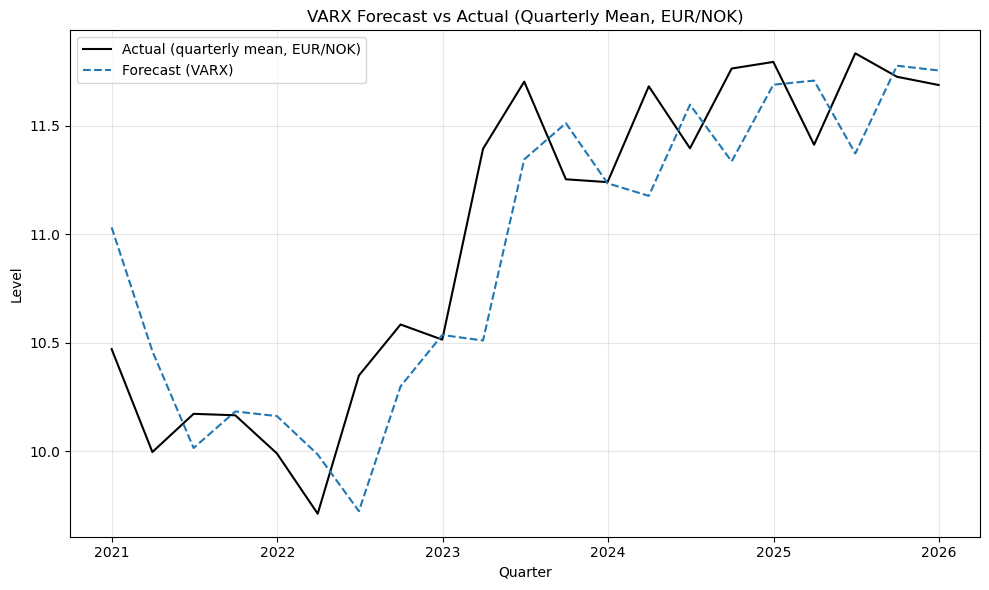

Saved: VARX_WalkForward_Quarterly.png


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
import math
import numpy as np  # assuming already imported elsewhere; safe to keep
import pandas as pd
import matplotlib.pyplot as plt

print("\n\n=== Starting VARX Walk-Forward Quarterly Evaluation ===")

# ----------------------------
# 1) Quarterly aggregation
# ----------------------------
df_q = df.resample("Q").last()  # last monthly observation per quarter
endog_q = df_q[endog_vars]
exog_q  = df_q[exog_vars]
eur_nok_q = df_q["EUR_NOK"]

quarters = df_q.index
train_cut = int(len(quarters) * 0.8)
p = 2  # lag order

print(f"Training quarters: {quarters[0].date()} → {quarters[train_cut-1].date()}")
print(f"Test quarters:     {quarters[train_cut].date()} → {quarters[-1].date()}")
print(f"Out-of-sample quarters: {len(quarters) - train_cut}")

# ----------------------------
# 2) Helper: one-step forecast
# ----------------------------
def forecast_one_step(endog_train, exog_train, exog_next, g_prev, p=2):
    model = VARMAX(endog_train, exog=exog_train, order=(p, 0))
    res = model.fit(maxiter=500, disp=False)
    f = res.get_forecast(steps=1, exog=exog_next).predicted_mean.iloc[0]
    q_hat, dpi_hat = f["Q"], f["d_pi"]
    g_new = g_prev - dpi_hat
    s_hat = q_hat + g_new
    return np.exp(s_hat), g_new

# ----------------------------
# 3) Walk-forward loop (parallel)
# ----------------------------
quarters_list = list(quarters)

def one_quarter_forecast(i):
    """
    Perform one-step-ahead forecast for a single quarter index i.
    Logic is identical to the original loop body.
    """
    q_prev = quarters_list[i - 1]
    q_curr = quarters_list[i]

    endog_train = endog_q.loc[:q_prev]
    exog_train  = exog_q.loc[:q_prev]
    exog_next   = exog_q.loc[[q_curr]]

    if len(endog_train) < 20:
        return None

    q_T = endog_train["Q"].iloc[-1]
    s_T = np.log(eur_nok_q.loc[q_prev])
    g_prev = s_T - q_T

    y_pred, g_prev = forecast_one_step(endog_train, exog_train, exog_next, g_prev, p=p)
    y_true = eur_nok_q.loc[q_curr]

    return {"quarter": q_curr, "y_true": y_true, "y_pred": y_pred}

# Run in parallel over all out-of-sample quarters
results = Parallel(n_jobs=-1, backend="loky", verbose=1)(
    delayed(one_quarter_forecast)(i)
    for i in range(train_cut, len(quarters_list))
)

rows = [r for r in results if r is not None]

df_eval = pd.DataFrame(rows).set_index("quarter").sort_index()
print(f"Completed {len(df_eval)} quarterly forecasts.")

# ----------------------------
# 4) Evaluate predictive performance
# ----------------------------
df_eval["err"] = df_eval["y_true"] - df_eval["y_pred"]
rmse = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_pred"]))
mae = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])

df_eval["y_prev"] = df_eval["y_true"].shift(1)
mask = df_eval["y_prev"].notna()
dir_true = np.sign(df_eval.loc[mask, "y_true"] - df_eval.loc[mask, "y_prev"])
dir_pred = np.sign(df_eval.loc[mask, "y_pred"] - df_eval.loc[mask, "y_prev"])
hit_rate = (dir_true == dir_pred).mean() * 100

print("\n=== VARX Walk-Forward Evaluation (Quarterly) ===")
print(f"Observations: {len(df_eval)}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"Directional accuracy: {hit_rate:.1f}%")

# ----------------------------
# 5) Diebold–Mariano test vs Random Walk
# ----------------------------
def _normal_cdf(z): 
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h=1, loss="mse"):
    df_dm = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df_dm.empty or len(df_dm) < 5:
        return np.nan, np.nan
    e_m, e_r = df_dm["y"] - df_dm["m"], df_dm["y"] - df_dm["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss == "mae" else (e_m**2) - (e_r**2)
    N = len(d)
    d_mean = d.mean()
    gamma0 = np.var(d, ddof=1)
    var_bar = gamma0 / N
    dm_stat = d_mean / np.sqrt(var_bar)
    p_val = 2 * (1 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

df_eval["rw_pred"] = df_eval["y_true"].shift(1)
dm_stat, p_val = dm_test(df_eval["y_true"], df_eval["y_pred"], df_eval["rw_pred"])

print("\n=== Diebold–Mariano Test vs Random Walk ===")
print(f"DM-statistic: {dm_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# ----------------------------
# 6) Plot forecast vs actual
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_eval.index, df_eval["y_true"], color="black", label="Actual (quarterly mean, EUR/NOK)")
plt.plot(df_eval.index, df_eval["y_pred"], color="tab:blue", linestyle="--", label="Forecast (VARX)")
plt.title("VARX Forecast vs Actual (Quarterly Mean, EUR/NOK)")
plt.xlabel("Quarter")
plt.ylabel("Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VARX_WalkForward_Quarterly.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: VARX_WalkForward_Quarterly.png")
